In [1]:
#Week 3: Churn Prediction for Streamworks Media

#Streamworks Media is a UK video streaming platform.  The primary purpose of this analysis is to understand customer churn patterns,
#and to predict churn probability to enable early intervention.  The analysis also sets out to explore revenue-impacting behaviours,
#such as watch time for streamed videos.

In [2]:
#Import dependency

import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;
import time;
import scipy.stats as stats;
from scipy.stats import chi2_contingency;
from scipy import stats;
from sklearn.metrics import confusion_matrix, classification_report;
from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LogisticRegression;
from sklearn.svm import SVC;

In [3]:
#Load data and explore it

streamworks_user_data_df = pd.read_csv ('streamworks_user_data.csv');

streamworks_user_data_df.info ();
streamworks_user_data_df_describe = streamworks_user_data_df.describe ();
streamworks_user_data_df_value_counts = streamworks_user_data_df.value_counts ();
streamworks_user_data_df_missing_values_count = streamworks_user_data_df.isnull ().sum ();

print ('\nDescribe Streamworks User Data:\n\n', streamworks_user_data_df_describe);
print ('\nStreamworks User Data value counts are\n\n', streamworks_user_data_df_value_counts);
print ('\nStreamworks User Data missing values count is\n\n', streamworks_user_data_df_missing_values_count);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB

Describe Streamworks U

In [4]:
#Clean dataframe

streamworks_user_data_df ['monthly_fee'] = streamworks_user_data_df ['monthly_fee'].fillna (0.0);

streamworks_user_data_df = streamworks_user_data_df.dropna ();

print (streamworks_user_data_df);

      user_id   age  gender signup_date last_active_date  country  \
0      1001.0  56.0   Other    02-04-25         13-07-25   France   
1      1002.0  69.0    Male    02-01-23         13-07-25    India   
2      1003.0  46.0    Male    21-08-22         13-07-25       UK   
3      1004.0  32.0   Other    14-09-23         13-07-25  Germany   
4      1005.0  60.0  Female    29-07-23         13-07-25    India   
...       ...   ...     ...         ...              ...      ...   
1494   2495.0  51.0    Male    16-11-22         13-07-25      USA   
1495   2496.0  40.0  Female    26-11-23         13-07-25   Canada   
1497   2498.0  28.0   Other    01-03-23         13-07-25       UK   
1498   2499.0  23.0  Female    24-10-22         13-07-25      USA   
1499   2500.0  35.0   Other    26-01-23         13-07-25   Canada   

     subscription_type  average_watch_hours  mobile_app_usage_pct  \
0             Standard                 42.6                  77.4   
1                Basic           

In [5]:
#Create correlation matrix of numeric variables

streamworks_user_data_numeric_df = streamworks_user_data_df.select_dtypes (include = [np.number]);
streamworks_user_data_corr_matrix = streamworks_user_data_numeric_df.corr (method = 'pearson');

print ('Correlation Matrix:\n', streamworks_user_data_corr_matrix);

Correlation Matrix:
                        user_id       age  average_watch_hours  \
user_id               1.000000 -0.015407            -0.018938   
age                  -0.015407  1.000000             0.039353   
average_watch_hours  -0.018938  0.039353             1.000000   
mobile_app_usage_pct -0.020698 -0.004027            -0.005661   
complaints_raised    -0.064942  0.028364            -0.013386   
is_churned           -0.000783 -0.002658            -0.007149   
monthly_fee          -0.014941  0.023720            -0.002613   

                      mobile_app_usage_pct  complaints_raised  is_churned  \
user_id                          -0.020698          -0.064942   -0.000783   
age                              -0.004027           0.028364   -0.002658   
average_watch_hours              -0.005661          -0.013386   -0.007149   
mobile_app_usage_pct              1.000000          -0.032016    0.023328   
complaints_raised                -0.032016           1.000000   -0.009137

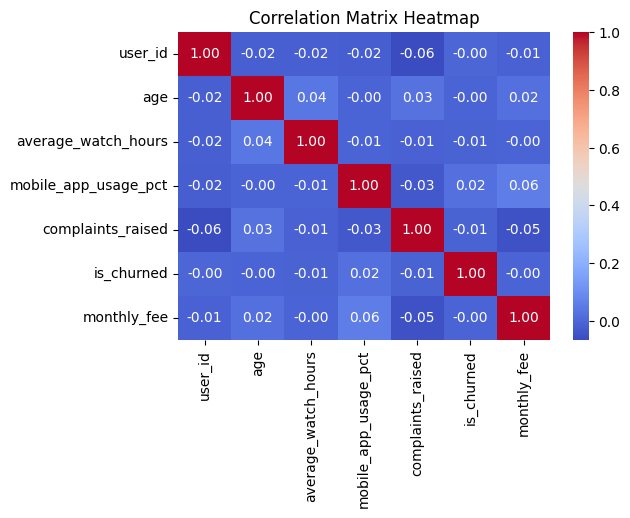

In [6]:
#Create heatmap of correlation matrix

plt.figure (figsize = (6, 4));
sns.heatmap (streamworks_user_data_corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f');
plt.title ('Correlation Matrix Heatmap');
plt.show ();

In [7]:
#Convert signup_date and last_active_date to datetime format

streamworks_user_data_df ['signup_date'] = pd.to_datetime (streamworks_user_data_df ['signup_date']);
streamworks_user_data_df ['last_active_date'] = pd.to_datetime (streamworks_user_data_df ['last_active_date']);

print (streamworks_user_data_df ['signup_date']);
print (streamworks_user_data_df ['last_active_date']);

C:\Users\edwar\AppData\Local\Temp\ipykernel_16172\2088955866.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  streamworks_user_data_df ['signup_date'] = pd.to_datetime (streamworks_user_data_df ['signup_date']);


0      2025-02-04
1      2023-02-01
2      2022-08-21
3      2023-09-14
4      2023-07-29
          ...    
1494   2022-11-16
1495   2023-11-26
1497   2023-01-03
1498   2022-10-24
1499   2023-01-26
Name: signup_date, Length: 1476, dtype: datetime64[ns]
0      2025-07-13
1      2025-07-13
2      2025-07-13
3      2025-07-13
4      2025-07-13
          ...    
1494   2025-07-13
1495   2025-07-13
1497   2025-07-13
1498   2025-07-13
1499   2025-07-13
Name: last_active_date, Length: 1476, dtype: datetime64[ns]


In [8]:
#Chi squared test

def test (variable, variable_name):
    stat, p, dof, expected = chi2_contingency ([nis_churned, variable]);

    alpha = 0.05;
    print ('p value is ' + str (p));

    if p <= alpha:
        print ('is_churned and ' + variable_name + ' are dependent (reject H0).');
    else:
        print ('is_churned and ' + variable_name + ' are independent (H0 holds true).');

nis_churned = [];
ngender = [];
nreceived_promotions = [];
nreferred_by_friend = [];

for i in range (0, 1475):

    nis_churned.append (int (streamworks_user_data_df.iloc [i]['is_churned']) + 1);
    
    if streamworks_user_data_df.iloc [i]['gender'] == 'Other':
        ngender.append (1);
    elif streamworks_user_data_df.iloc [i]['gender'] == 'Female':
        ngender.append (2);
    else:
        ngender.append (3);

    if streamworks_user_data_df.iloc [i]['received_promotions'] == 'Yes':
        nreceived_promotions.append (2);
    else:
        nreceived_promotions.append (1);

    if streamworks_user_data_df.iloc [i]['referred_by_friend'] == 'Yes':
        nreferred_by_friend.append (2);
    else:
        nreferred_by_friend.append (1);

test (ngender, 'gender');
test (nreceived_promotions, 'received_promotions');
test (nreferred_by_friend, 'referred_by_friend');

p value is 1.0
is_churned and gender are independent (H0 holds true).
p value is 1.0
is_churned and received_promotions are independent (H0 holds true).
p value is 1.0
is_churned and referred_by_friend are independent (H0 holds true).


In [9]:
#t-test

mean_average_watch_hours = np.average (streamworks_user_data_df ['average_watch_hours']);
mean_is_churned = np.average (streamworks_user_data_df ['is_churned']);

x = np.random.randn (1476) + mean_average_watch_hours;
y = np.random.randn (1476) + mean_is_churned;

t_stat, p_val = stats.ttest_ind (x, y);

alpha = 0.05;
print ('t-statistic = ' + str (t_stat));
print ('p-value = ' + str (p_val));

if p_val <= alpha:
    print ('Watch time and churned/retained are dependent (reject H0).');
else:
    print ('Watch time and churned/retained are independent (H0 holds true).');

t-statistic = 1072.1778355036652
p-value = 0.0
Watch time and churned/retained are dependent (reject H0).


In [10]:
#Correlation analysis

corr1, _ = stats.pearsonr (nis_churned, ngender);
corr2, _ = stats.pearsonr (nis_churned, nreceived_promotions);
corr3, _ = stats.pearsonr (nis_churned, nreferred_by_friend);

naverage_watch_hours = [];
for i in range (0, 1475):
    naverage_watch_hours.append (streamworks_user_data_df.iloc [i]['average_watch_hours']);
corr4, _ = stats.pearsonr (nis_churned, naverage_watch_hours);

print ('Coefficient of correlation between churned/retained and gender is', corr1);
print ('Coefficient of correlation between churned/retained and received_promotions is', corr2);
print ('Coefficient of correlation between churned/retained and referred_by_friend is', corr3);
print ('Coefficient of correlation between churned/retained and watch time is', corr4);

Coefficient of correlation between churned/retained and gender is -0.002143456128634118
Coefficient of correlation between churned/retained and received_promotions is -0.043238574796676955
Coefficient of correlation between churned/retained and referred_by_friend is -0.017210884178793757
Coefficient of correlation between churned/retained and watch time is -0.006545349454821102


In [11]:
#Logistic regression

df = pd.DataFrame ({'nis_churned': nis_churned, 'ngender': ngender, 'nreceived_promotions': nreceived_promotions, 'nreferred_by_friend': nreferred_by_friend, 'naversge_watch_hours': naverage_watch_hours});

y = df ['nis_churned'];
X = df.drop ('nis_churned', axis = 1);

X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1);

classifier = LogisticRegression (solver = 'lbfgs', random_state = 1);
classifier.fit (X_train, y_train);
predictions = classifier.predict (X_test);

print (confusion_matrix (y_test, predictions));

target_names = ['0', '1'];

print (classification_report (y_test, predictions, target_names = target_names));

[[282   0]
 [ 87   0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87       282
           1       0.00      0.00      0.00        87

    accuracy                           0.76       369
   macro avg       0.38      0.50      0.43       369
weighted avg       0.58      0.76      0.66       369



C:\Users\edwar\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\edwar\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\edwar\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave